In [24]:
import torch, torchvision
from torch import nn, optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
#from torch.utils import make_grid
from torchvision import datasets, transforms, models
import timm
from timm.loss import LabelSmoothingCrossEntropy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
from tqdm import tqdm
import time
import copy
import numpy as np
from timeit import default_timer as timer
from datetime import timedelta
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
data_dir = './Covid-dataset-split/'
train_dir = data_dir + r'train/'
valid_dir = data_dir + r'val/'
test_dir = data_dir + r'test/'

normal_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

training_dataset = datasets.ImageFolder(train_dir, transform=normal_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform=normal_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform=normal_transforms)

train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True, pin_memory=True)
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=False, pin_memory=True)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=32, shuffle=False, pin_memory=True)

print(len(training_dataset), validation_dataset[20][0].shape, testing_dataset[10][1])

dataloaders = {'train': train_loader, 'val': validate_loader}
dataset_sizes = {'train': len(training_dataset), 'val': len(validation_dataset)}

def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes
classes = get_classes(train_dir)
classes

6326 torch.Size([3, 224, 224]) 0


['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']

In [15]:
model1 = models.mobilenet_v2(pretrained=True)
model1.classifier[1] = nn.Linear(1280, len(classes))
model1 = model1.to(device)

c:\Users\hydon\anaconda3\envs\torch112_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\hydon\anaconda3\envs\torch112_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\hydon/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 23.1MB/s]


In [16]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model1.parameters(), lr = 0.0008)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

def train_model(model, criterion, optimizer, scheduler, num_epoch=3):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    val_losses = []
    train_losses = []
    val_acc = []
    train_acc = []
    x = np.arange(1, num_epoch+1)

    for epoch in range(num_epoch):
        print(f"Epoch {epoch}/{num_epoch - 1}")
        print("-" * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)  # outputs: [batch_size, classes]，就是每个类别都预测一个概率数
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                train_losses.append(float(epoch_loss))
                train_acc.append(float(epoch_acc))
            else:
                val_losses.append(float(epoch_loss))
                val_acc.append(float(epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best Val Acc: {best_acc:.4f}")

    plt.style.use('seaborn')
    fig1, ax1 = plt.subplots()  # axis x, y legend
    fig2, ax2 = plt.subplots()
    ax1.plot(x, val_losses, color='#444444', linestyle='--', label='validation loss')
    ax1.plot(x, train_losses, linestyle='--', label='train loss')
    ax1.legend()
    ax1.set_title('train loss & validation loss')
    ax1.set_ylabel('loss value')
    ax1.set_xlabel('epoch')
    ax2.plot(x, val_acc, color='#444444', linestyle='--', label='validation acc')
    ax2.plot(x, train_acc, linestyle='--', label='train acc')
    ax2.legend()
    ax2.set_title('train acc & validation acc')
    ax2.set_ylabel('acc value')
    ax2.set_xlabel('epoch')
    plt.tight_layout()
    plt.show()
    #fig1.savefig('loss resnet18.png', dpi=800)
    #fig2.savefig('acc resnet18.png', dpi=800)

    # 加载最优权重
    model.load_state_dict(best_model_wts)
    return model

Epoch 0/2
----------


100%|██████████| 198/198 [02:54<00:00,  1.13it/s]


train Loss: 0.0000 Acc: 0.9377


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


val Loss: 0.0000 Acc: 0.8421

Epoch 1/2
----------


100%|██████████| 198/198 [02:42<00:00,  1.22it/s]


train Loss: 0.0000 Acc: 0.9714


100%|██████████| 2/2 [00:00<00:00,  2.53it/s]


val Loss: 0.0000 Acc: 0.8947

Epoch 2/2
----------


100%|██████████| 198/198 [02:40<00:00,  1.23it/s]


train Loss: 0.0000 Acc: 0.9801


100%|██████████| 2/2 [00:00<00:00,  2.73it/s]
C:\Users\hydon\AppData\Local\Temp\ipykernel_15184\3704733322.py:63: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


val Loss: 0.0000 Acc: 0.9211

Training complete in 8m 26s
Best Val Acc: 0.9211


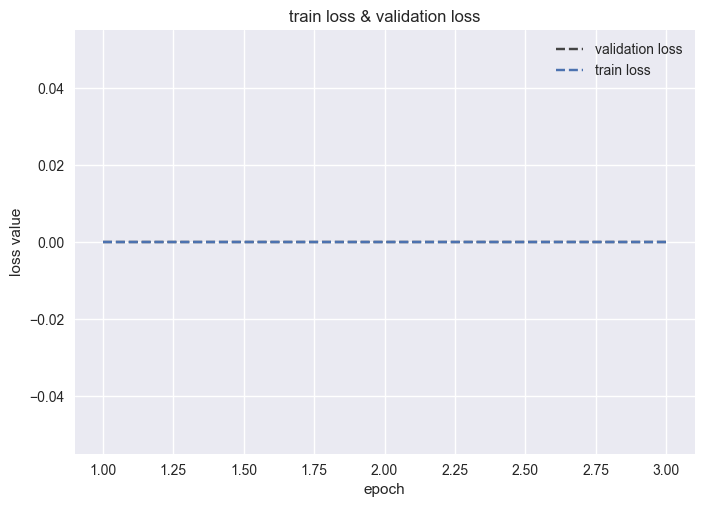

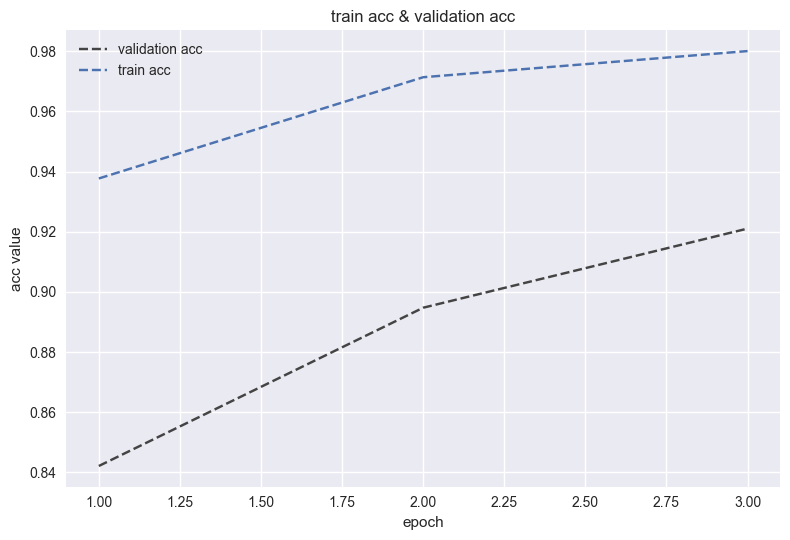

0:08:26.628887
######### end #########


In [18]:
start = timer()
model1_trained = train_model(model1, criterion, optimizer, exp_lr_scheduler)
torch.save(model1_trained, 'mobilenetv2_trained_cov_3_based_on_1')
end = timer()
print(timedelta(seconds=end-start))
print("######### end #########")

# Validation and Inference

In [22]:
model_trained = torch.load('./mobilenetv2_trained_cov_3_based_on_1')
model_trained.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

preds val is  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
preds val is  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
preds val is  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
preds val is  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
        2, 1, 2, 2, 1, 1, 1, 1], device='cuda:0')
preds val is  tensor([1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2,
        2, 2, 2, 2, 2, 1, 2, 1], device='cuda:0')
preds val is  tensor([2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3,
        1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0')
preds val is  tensor([1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 1, 2, 2], device='c

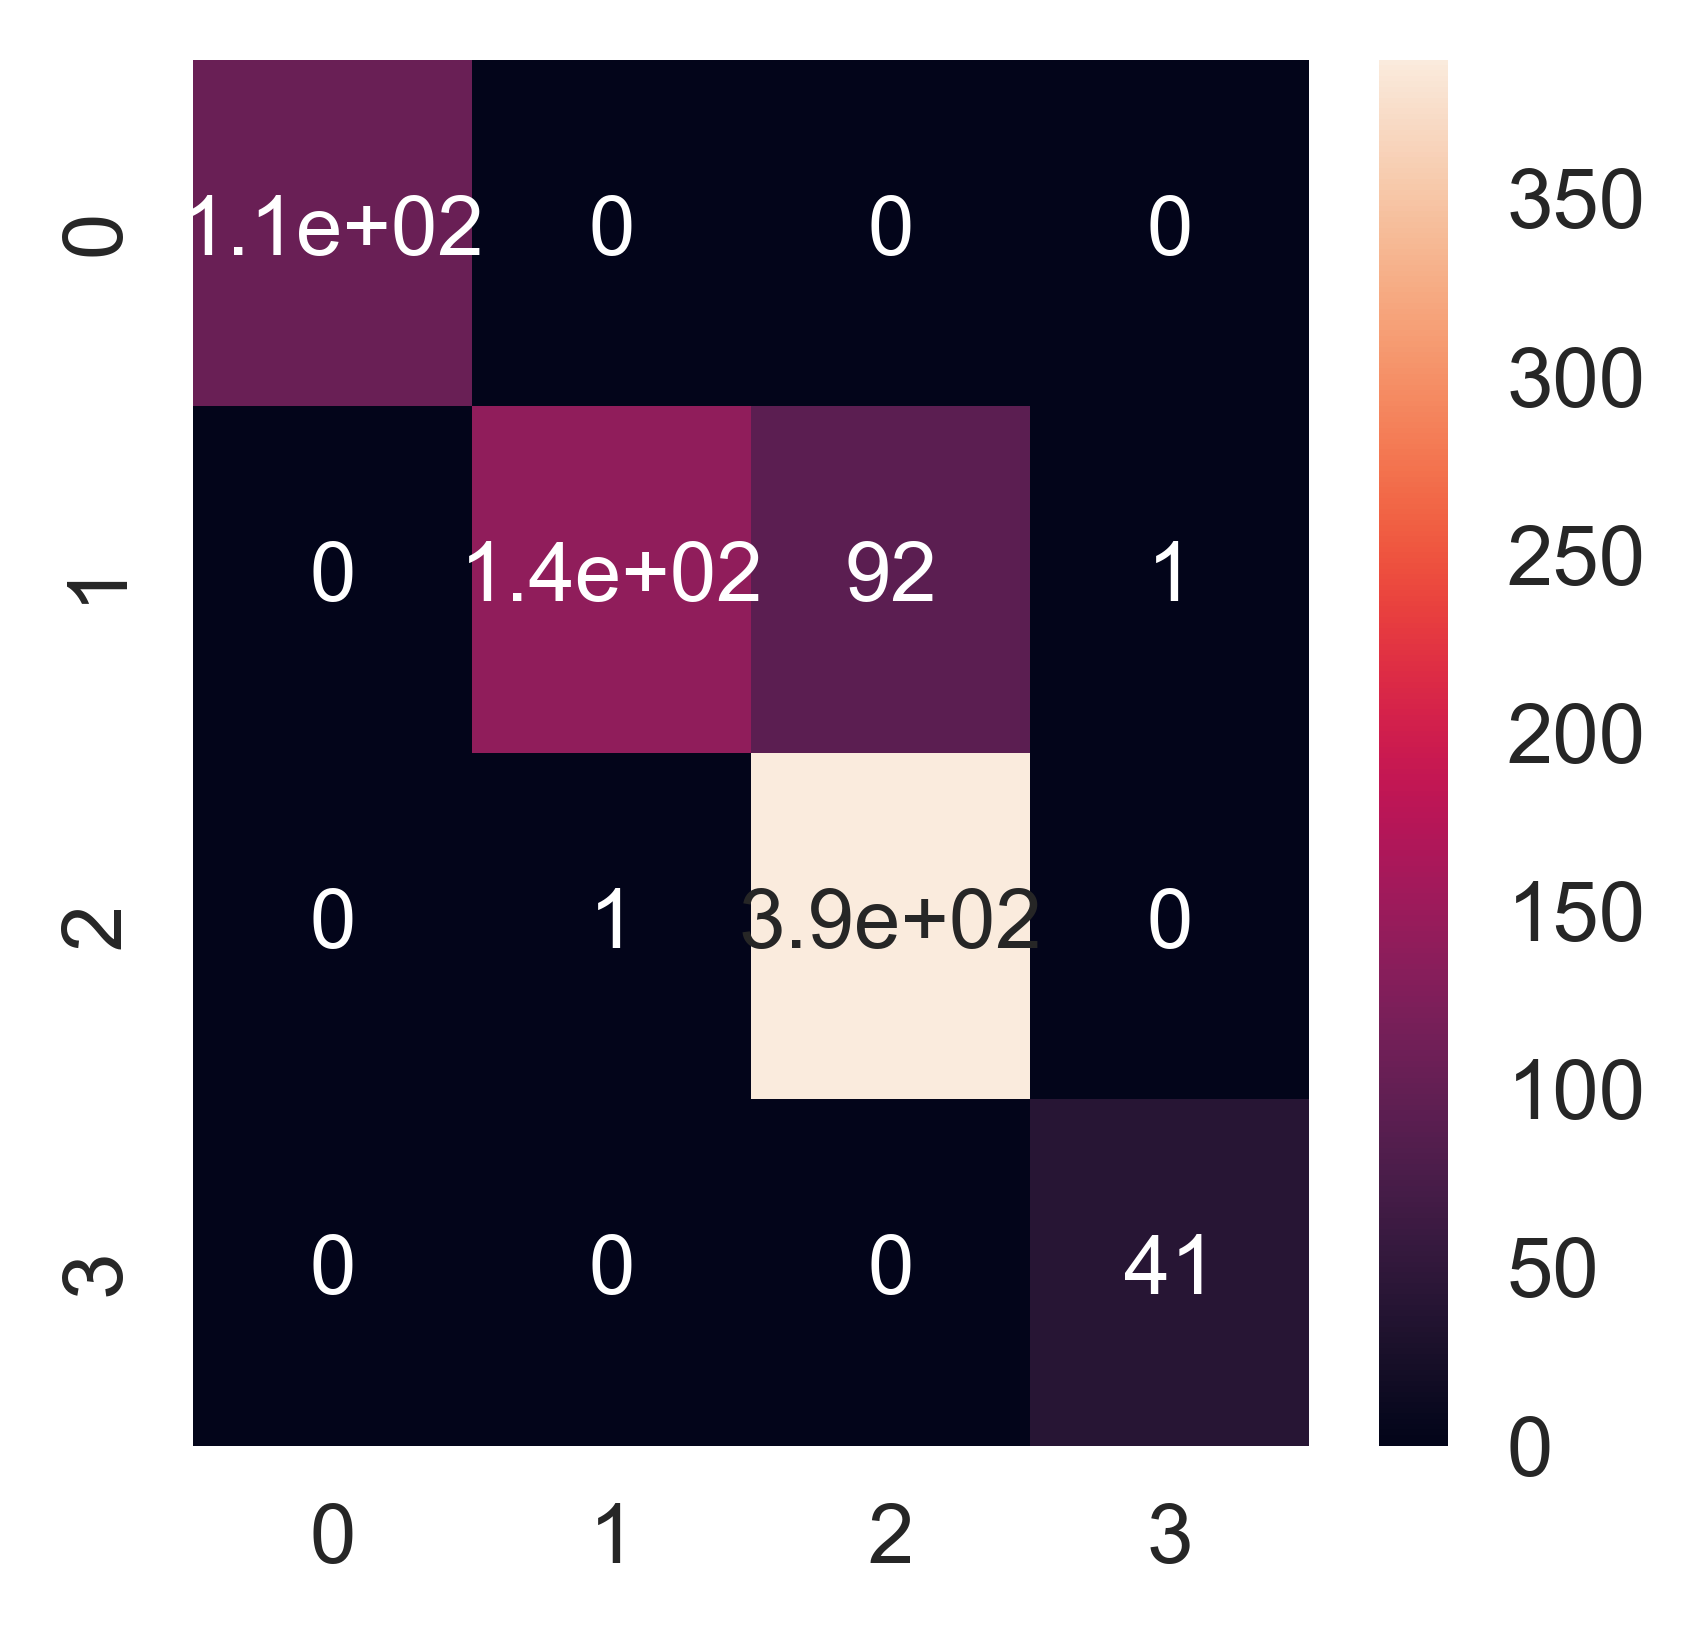

In [29]:
class_acc = []
def single_model_eval(model):
    predlist = torch.zeros(0, dtype=torch.long, device='cuda')
    lbllist = torch.zeros(0, dtype=torch.long, device='cuda')

    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print('preds val is ', preds)
            predlist = torch.cat([predlist, preds])
            lbllist = torch.cat([lbllist, classes])
    conf_mat = confusion_matrix(lbllist.cpu().numpy(), predlist.cpu().numpy())
    precision_recall_fscore = precision_recall_fscore_support(lbllist.cpu().numpy(), predlist.cpu().numpy(), average='weighted')
    print(f'precision_recall_fscore is {precision_recall_fscore}')

    print(conf_mat)
    plt.figure(figsize=(3, 3), dpi=600)
    sns.heatmap(conf_mat, annot=True)
    class_accuracy = 100 * conf_mat.diagonal() / conf_mat.sum(1)
    print("Testset accuracy: ", class_accuracy)
    class_acc.append(class_accuracy)
mlist = [model_trained]
for i in mlist:
    single_model_eval(i)